In [173]:
%cd "/content/drive/MyDrive/Colab Notebooks/데이콘/영화리뷰감성분석경진대회/"
!unzip "dataset.zip"

/content/drive/MyDrive/Colab Notebooks/데이콘/영화리뷰감성분석경진대회
Archive:  dataset.zip
replace dataset/sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: dataset/sample_submission.csv  
replace dataset/test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: dataset/test.csv        
replace dataset/train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: dataset/train.csv       


#### 1. 데이터 로드하기

In [174]:
# 현재 작업 경로를 얻는 함수
import os
print(os.getcwd())

/content/drive/My Drive/Colab Notebooks/데이콘/영화리뷰감성분석경진대회


In [175]:
# 데이터 불러오기
import pandas as pd

train = pd.read_csv("./dataset/train.csv")
test = pd.read_csv("./dataset/test.csv")
submission = pd.read_csv("./dataset/sample_submission.csv")

In [176]:
# train 데이터 상위 행 3개
train.head(3)

,id,document,label
0,1,영상이나 음악이 이쁘다 해도 미화시킨 불륜일뿐,0
1,2,히치콕이 이 영화를 봤다면 분명 박수를 쳤을듯...,1
2,3,괜찮은 음악영화가 또 나왔군요!!! 따뜻한 겨울이 될 것 같아요~,1


In [177]:
# test 데이터 상위 행 3개
test.head(3)

,id,document
0,1,시간 때우기 좋은 영화 지루함
1,2,훈훈한 정이 느껴지는 영화! 가족끼리 드라마 보듯이 보면 딱~!
2,3,Childhood fantasy


In [178]:
# train, test 데이터의 shape(모양)
print(train.shape)
print(test.shape)

(5000, 3)
(5000, 2)


**[정리]**

- train 데이터는 id, document, label 열을 가지고 있고, test 데이터는 id, document 열을 가지고 있습니다.

- train 데이터와 test 데이터는 각각 5000개의 리뷰를 가지고 있으며 train 데이터를 이용하여 모형을 학습시키고 test 데이터에 적용하여 label을 찾아내는 대회입니다.

#### 2. 데이터 정제하기

In [179]:
train['document'].nunique(), train['label'].nunique()

(5000, 2)

In [180]:
test['document'].nunique()

4999

- nunique()는 unique() 함수의 반대로 해석하면 됩니다. unique()는 유일한 값을 추출하는 함수인데 non unique()는 데이터 중복 유무를 확인하여 출력하는 함수입니다.

- 여기서 train 데이터는 중복값이 없다는 것을 확인할 수 있습니다. document열에 대하여 5000개의 리뷰가 있기 때문에 출력시 5000개가 나오고 label열에 대하여 긍정/부정 2가지이기 때문에 2개가 나왔습니다.

- 그런데 test document열에 대하여 5000개의 리뷰 중 **4999**개가 출력 되었습니다. 이는 **하나의 중복 샘플이 존재한다는 의미**입니다. 하지만 우리는 test 데이터의 결과를 예측하는 문제이기 때문에 제거하지 않고 진행을 할 것입니다. '겹치는 리뷰가 있다' 정도만 알고 넘어가면 될 것 같습니다.

In [181]:
# label의 분포
train['label'].value_counts()

0    2564
1    2436
Name: label, dtype: int64

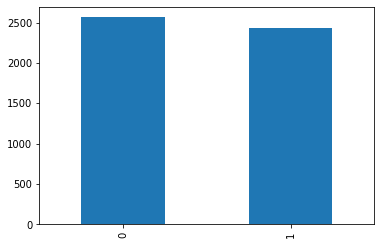

In [182]:
# label의 분포 시각화
train['label'].value_counts().plot(kind='bar')

- train 데이터가 가지고 있는 라벨 값의 분포가 크게 차이가 나지 않기 때문에 y값은 따로 건들지 않아도 될 것 같습니다. 

- 만약에 라벨 값의 분포가 100 : 4900 이렇게 된다면 이는 여러 기법을 가지고 조정을 해야 합니다. 위 내용은 다음 게시글에서 준비해보겠습니다.

In [183]:
# 결측치 확인
train.isnull().sum()

id          0
document    0
label       0
dtype: int64

- null값을 가진 샘플을 제거하기 위해 살펴봤는데 없으므로 넘어갑니다.

In [184]:
train.head()

,id,document,label
0,1,영상이나 음악이 이쁘다 해도 미화시킨 불륜일뿐,0
1,2,히치콕이 이 영화를 봤다면 분명 박수를 쳤을듯...,1
2,3,괜찮은 음악영화가 또 나왔군요!!! 따뜻한 겨울이 될 것 같아요~,1
3,4,아무래도 20년도지난작품이라 지금보기는너무유치하다,0
4,5,지금까지의 영화들이 그랬듯. 이 영화역시 일본에 대한 미화는 여전하다.,0


- 아이디 3번에 '**!!!**' 처럼 각종 특수문자가 사용된 것이 확인됩니다. 따라서 한글만 남기고 제거하기 위해 정규표현식을 이용하여 나타내어 보겠습니다.

- 정규표현식은 특정한 규칙을 가진 문자열의 집합을 표현하는데 사용하는 형식 언어입니다.(위키백과)

- 우리는 위 리뷰에서 모/자음만 있는 한글과 공백을 추려내는 정규식을 사용하여 쉽게 추출, 제거해보겠습니다.

- 한글 코드 범위는 다음과 같습니다.

|한글|코드 범위|
|------|---|
|ㄱ ~ ㅎ|0x3131 ~ 0x314e|
|ㅏ ~ ㅣ|0x314f ~ 0x3163|
|가 ~ 힣|0xac00 ~ 0xd7a3|



In [185]:
train['document'] = train['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")

In [186]:
train.head()

,id,document,label
0,1,영상이나 음악이 이쁘다 해도 미화시킨 불륜일뿐,0
1,2,히치콕이 이 영화를 봤다면 분명 박수를 쳤을듯,1
2,3,괜찮은 음악영화가 또 나왔군요 따뜻한 겨울이 될 것 같아요,1
3,4,아무래도 년도지난작품이라 지금보기는너무유치하다,0
4,5,지금까지의 영화들이 그랬듯 이 영화역시 일본에 대한 미화는 여전하다,0


- id 3번에 '**!!!**'이 제거된 것을 확인할 수 있습니다. 동일하게 test 데이터에도 적용하겠습니다.

In [187]:
test['document'] = test['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")

#### 3. 토큰화

- 자연어 처리에서 전처리되지 않은 상태라면 해당 데이터를 용도에 맞게 전처리를 해야합니다. 전처리 기법 중 토큰화는 토큰(token)이라 불리는 단위로 나누는 작업입니다.

- 위 단계에서는 토큰화 과정에서 불용어를 제거해보겠습니다. 불용어란 의미가 없는 단어를 의미합니다. 사용자 정의에 따라 더 다양한 불용어를 사용할 수 있습니다.


In [188]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

- 파이썬 한국어 형태소 분석 패키지인 KoNLPy가 있는데 이 안에 여러 종류의 한국어 형태소 분석기가 있습니다. 그 중에 OKt 형태소 분석기를 사용하여 제거합니다.

-  OKt(Open Korean Text)는 트위터에서 만든 오픈소스 한국어 처리기인 twitter-korean-text를 이어받아 만들고 있는 프로젝트라고 합니다. 형태소 분석기 중에선 시간이 빠르진 않지만 합리적인 시간을 가지고 있어서 자주 사용된다고 합니다.

In [189]:
# 패키지 설치
!pip install konlpy

In [190]:
from tqdm import tqdm
from konlpy.tag import Okt
X_train = [] # 리스트 생성
okt = Okt() # 형태소 분석기 정의
for sentence in tqdm(train['document']): # document 문장을 가져와서
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_train.append(stopwords_removed_sentence) # 리스트 안에 append

100%|██████████| 5000/5000 [00:15<00:00, 323.28it/s]


In [191]:
# 잘 제거 되었는지 확인
print(X_train[:3])

[['영상', '이나', '음악', '이쁘다', '해도', '미화', '시키다', '불륜', '일', '뿐'], ['히치콕', '영화', '보다', '분명', '박수', '치다'], ['괜찮다', '음악', '영화', '또', '나오다', '따뜻하다', '겨울', '되다', '것', '같다']]


In [192]:
# test 데이터에도 같은 작업 반복
X_test = []
for sentence in tqdm(test['document']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_test.append(stopwords_removed_sentence)

100%|██████████| 5000/5000 [00:15<00:00, 318.41it/s]


#### 4. 정수 인코딩

- 숫자로 처리할 수 있도록 정수 인코딩(encoding)을 진행해보겠습니다.

-  정수 인코딩이란 텍스트를 숫자로 바꾸는 기법입니다. 우리는 텍스트를 보고 부정/긍정을 빠르게 파악할 수 있지만 인공지능은 파악하기 어렵기 때문에 텍스트를 정수에 매핑시키는 기법입니다. 

- 우선 데이터에 대해 단어 집합을 만들어야 합니다.

In [193]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
tokenizer = Tokenizer() # 토큰화
tokenizer.fit_on_texts(X_train) # 단어 인덱스 구축

In [197]:
# 단어 mapping 기준은 단어 빈도수
#print(tokenizer.word_index)

- 단어 집합을 생성하면서 단어에 고유 정수가 붙었습니다. 이를 word_index를 통해 출력하면 고유 정수가 무엇인지 알 수 있습니다.

- 각 정수는 전체 데이터에서 등장 빈도가 높은 순서대로 부여되었습니다. 따라서 위 5000개의 리뷰 중에 '영화' 단어가 가장 많이 나왔다는 것을 확인할 수 있습니다.


- 이제는 등장 빈도수가 낮은 단어가 얼마나 있는지 파악하고 제거 여부를 생각해봅시다.

In [198]:
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수 = 6648개
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value 

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1 # 카운트
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 6648
등장 빈도가 2번 이하인 희귀 단어의 수: 4640
단어 집합에서 희귀 단어의 비율: 69.79542719614922
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 13.715559648145007


- 전체 등장 빈도에서 2번 이하인 희귀 단어 등장 빈도 비율이 13%나 되기 때문에 우리는 등장 빈도가 낮은 친구들을 삭제하지 않겠습니다. 삭제하면 많은 데이터가 삭제되기 때문입니다.

In [199]:
# 아무것도 삭제 안할거라서 크기는 그대로!
vocab_size = total_cnt
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 6648


- texts_to_sequences를 이용하여 정수 시퀀스로 변환을 하겠습니다.

In [200]:
tokenizer = Tokenizer(vocab_size) 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_train[:3]

[[256, 192, 182, 238, 619, 929, 329, 930, 196, 151],
 [2009, 1, 2, 746, 931, 377],
 [148, 182, 1, 116, 25, 218, 1560, 16, 30, 21]]

In [201]:
X_test = tokenizer.texts_to_sequences(X_test)
X_test[:3]

[[42, 723, 7, 1, 321], [791, 1204, 361, 1, 458, 1670, 47, 2, 2, 406], []]

- 정수 인코딩 형식으로 잘 바뀐 것을 확인할 수 있습니다.

In [202]:
print(len(X_train))

5000


In [203]:
print(len(X_test))

5000


굳

#### 6. 패딩

- 서로 다른 길이의 샘플들의 길이를 동일하게 맞취주는 것을 패딩이라고 합니다. 

- 이미지를 다루는 딥러닝에서는 패딩을 이용하여 이미지에 마치 패딩을 입은 것처럼 0 또는 지정 숫자를 둘러주어 정보의 손실을 막습니다.

In [204]:
print("가장 긴 리뷰의 길이", max(len(review) for review in X_train))
print("리뷰의 평균 길이", sum(map(len, X_train))/len(X_train))

가장 긴 리뷰의 길이 19
리뷰의 평균 길이 8.2532


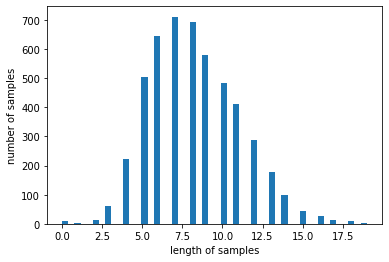

In [205]:
# train 데이터의 리뷰의 길이 시각화
import matplotlib.pyplot as plt
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [206]:
# train 데이터의 길이 출력
#for i in range(len(X_train)):
  #print(len(X_train[i]))

In [207]:
# 전체 샘플 중 길이가 %s 이하인 샘플의 비율 함수 정의
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [208]:
max_len = 15 # 임의로 설정해줌
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 15 이하인 샘플의 비율: 98.98


- 샘플 중 길이가 15 이하인 샘플의 비율이 98%나 되기 때문에 15로 길이를 맞춰주어 패딩하겠습니다.

In [209]:
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [210]:
y_train = train['label']

In [211]:
print(X_train.shape)
print(X_test.shape)

(5000, 15)
(5000, 15)


In [212]:
X_train[:3]

array([[   0,    0,    0,    0,    0,  256,  192,  182,  238,  619,  929,
         329,  930,  196,  151],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0, 2009,    1,
           2,  746,  931,  377],
       [   0,    0,    0,    0,    0,  148,  182,    1,  116,   25,  218,
        1560,   16,   30,   21]], dtype=int32)

- 다음 X_train[:3]를 살펴봤을때 길이가 15개가 안되는 리뷰에 대하여 패딩을 수행하여 0으로 채워져 있는 것을 확인할 수 있다.

#### 7. 모델링

- 전처리 작업은 이정도로 하고 모델링을 통해 결과를 도출해보겠습니다.

**7-1) 간단한 LSTM**

In [213]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os.path as osp
from konlpy.tag import Okt
import re

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [214]:
embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=12, validation_split=0.2)

Epoch 1/15
334/334 [==============================] - ETA: 0s - loss: 0.4575 - acc: 0.7775
Epoch 00001: val_acc improved from -inf to 0.83900, saving model to best_model.h5
334/334 [==============================] - 10s 23ms/step - loss: 0.4575 - acc: 0.7775 - val_loss: 0.3693 - val_acc: 0.8390
Epoch 2/15
334/334 [==============================] - ETA: 0s - loss: 0.2439 - acc: 0.9060
Epoch 00002: val_acc improved from 0.83900 to 0.85200, saving model to best_model.h5
334/334 [==============================] - 8s 23ms/step - loss: 0.2439 - acc: 0.9060 - val_loss: 0.3757 - val_acc: 0.8520
Epoch 3/15
333/334 [============================>.] - ETA: 0s - loss: 0.1854 - acc: 0.9294
Epoch 00003: val_acc improved from 0.85200 to 0.85400, saving model to best_model.h5
334/334 [==============================] - 8s 23ms/step - loss: 0.1858 - acc: 0.9293 - val_loss: 0.3584 - val_acc: 0.8540
Epoch 4/15
334/334 [==============================] - ETA: 0s - loss: 0.1543 - acc: 0.9402
Epoch 00004: val_

In [215]:
load_to_model = load_model('best_model.h5')
y_pred = load_to_model.predict(X_test)

In [216]:
y_pred # 0.5를 기준으로 0과 1을 분류

array([[0.00878313],
       [0.99905294],
       [0.5083071 ],
       ...,
       [0.99995315],
       [0.0235379 ],
       [0.99449414]], dtype=float32)

In [217]:
for i in range(len(y_pred)):
  if y_pred[i] < 0.5:
    y_pred[i] = 0
  else:
    y_pred[i]=1

In [218]:
y_pred

array([[0.],
       [1.],
       [1.],
       ...,
       [1.],
       [0.],
       [1.]], dtype=float32)

In [219]:
submission['label'] = y_pred
submission.to_csv("LSTM(1).csv", index=False) # 0.8415

- X_test에 대한 긍/부정 결과가 84.15 accuracy로 무난히 나왔는데 LSTM은 딥러닝 모형이니 추가적으로 layer를 추가하였을때는 결과값이 어떻게 변하는지 살펴봅시다.

**7-2) layer 추가 LSTM**

In [220]:
embedding_dim = 1000
embedding_dim2 = 64
embedding_dim3 = 32
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(embedding_dim2))
model.add(Dense(embedding_dim3))
model.add(Dense(1, activation='sigmoid'))

In [221]:
# 모형 summary 확인
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_15 (Embedding)    (None, None, 1000)        6648000   
                                                                 
 lstm_13 (LSTM)              (None, 128)               578048    
                                                                 
 dense_14 (Dense)            (None, 64)                8256      
                                                                 
 dense_15 (Dense)            (None, 32)                2080      
                                                                 
 dense_16 (Dense)            (None, 1)                 33        
                                                                 
Total params: 7,236,417
Trainable params: 7,236,417
Non-trainable params: 0
_________________________________________________________________


In [222]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=6)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=12, validation_split=0.2)

Epoch 1/15
334/334 [==============================] - ETA: 0s - loss: 0.4051 - acc: 0.8125
Epoch 00001: val_acc improved from -inf to 0.85700, saving model to best_model.h5
334/334 [==============================] - 30s 82ms/step - loss: 0.4051 - acc: 0.8125 - val_loss: 0.3474 - val_acc: 0.8570
Epoch 2/15
334/334 [==============================] - ETA: 0s - loss: 0.2092 - acc: 0.9128
Epoch 00002: val_acc did not improve from 0.85700
334/334 [==============================] - 27s 80ms/step - loss: 0.2092 - acc: 0.9128 - val_loss: 0.3978 - val_acc: 0.8420
Epoch 3/15
334/334 [==============================] - ETA: 0s - loss: 0.1350 - acc: 0.9463
Epoch 00003: val_acc did not improve from 0.85700
334/334 [==============================] - 27s 80ms/step - loss: 0.1350 - acc: 0.9463 - val_loss: 0.5206 - val_acc: 0.8430
Epoch 4/15
334/334 [==============================] - ETA: 0s - loss: 0.0806 - acc: 0.9678
Epoch 00004: val_acc did not improve from 0.85700
334/334 [==========================

In [223]:
load_to_model = load_model('best_model.h5')
y_pred = load_to_model.predict(X_test)

In [224]:
for i in range(len(y_pred)):
  if y_pred[i] < 0.5:
    y_pred[i] = 0
  else:
    y_pred[i]=1

In [225]:
submission['label'] = y_pred
submission.to_csv("LSTM(2).csv", index=False) # 0.8470

#### **[고찰]**

1. 제가 한 데이터 처리 과정을 주관을 많이 넣어서 선택적으로 하였습니다. 전처리에 따라서 다양한 데이터를 표현할 수 있습니다.
2. 같은 전처리를 한 데이터를 이용하여 모형을 조금 다르게 하였더니 판단 척도인 accuracy가 0.841 -> 0.847로 증가함을 보였습니다. 

3. 조금 더 깊은 layer의 모형과 epochs, batch size 등의 parameters를 조절한다면 더 좋은 결과가 나올 것 같습니다.

#### **[Reference]**

[1] 딥러닝을 이용한 자연어 처리 입문 : https://wikidocs.net/94600 <br>

[2] jihyeheo github : https://github.com/jihyeheo/DAC5_Exercise_movement_classification_ai_contest/blob/main/Modeling/20210119_%EB%B2%A0%EC%9D%B4%EC%8A%A4%EB%9D%BC%EC%9D%B8_LSTM.ipynb <br>

[3] 운동 동작 분류 AI 경진대회 베이스라인 코드 : https://dacon.io/competitions/official/235689/codeshare/2290?page=1&dtype=recent
